In [1]:
import pprint
import torch
import numpy as np

In [2]:
import pickle
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
try:
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
except:
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
print(f"Using {device} as device")

Using cuda as device


### Load Hyperstyle Model

In [4]:
def load_hyperstyle():
    os.chdir(f"{ROOT_PATH}/hyperstyle/")
    from utils.model_utils import load_model
    global tensor2im
    from utils.common import tensor2im

    model_path = f"{DATA_PATH}/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt"
    net, opts = load_model(model_path)
    print('Model successfully loaded!')
    #pprint.pprint(vars(opts))

    # Get Generator
    G = net.decoder

    os.chdir(f"{current_wd}")
    return G

### Load Latents and Weight Deltas

In [5]:
def load_generator_inputs(sku):
    hyperstyle_inference_base_path = f'{DATA_PATH}/Generated_Images/hyperstyle/'
    latents = np.load(f"{hyperstyle_inference_base_path}latents.npy", allow_pickle=True).item()
    latent = latents[f'{sku}.jpg']
    latent = torch.Tensor(latent).to(device)
    weight_delta = np.load(f"{hyperstyle_inference_base_path}weight_deltas/{sku}.npy", allow_pickle=True)
    weight_delta = list(weight_delta)
    weight_delta = [torch.Tensor(elem).to(device) if elem is not None else None for elem in weight_delta]

    return latent, weight_delta

In [6]:
def generate_hyperstyle(latent, weight_delta, G, return_image = False):
    # Generate image from latent
    gen = G([latent.unsqueeze(0)], 
            weights_deltas=weight_delta, input_is_latent=True)[0]
    img = tensor2im(gen.squeeze(0))

    if return_image:
        return gen, img 
    else: 
        return gen

In [7]:
G = load_hyperstyle()

Loading HyperStyle from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt
Loading pretrained W encoder...
Loading ReStyle e4e from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/restyle/00005_snapshot_1200/checkpoints/best_model.pt
Model successfully loaded!


In [8]:
# torch.save(G, 'G.pt')
# os.chdir(f"{ROOT_PATH}/hyperstyle/")
# G = torch.load('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/2_Inversion/hyperstyle/G.pt')
# os.chdir(current_wd)

In [9]:
sku = "02R21C00O-Q11"
latent, weight_delta = load_generator_inputs(sku)
gen, img = generate_hyperstyle(latent, weight_delta, G, return_image=True)

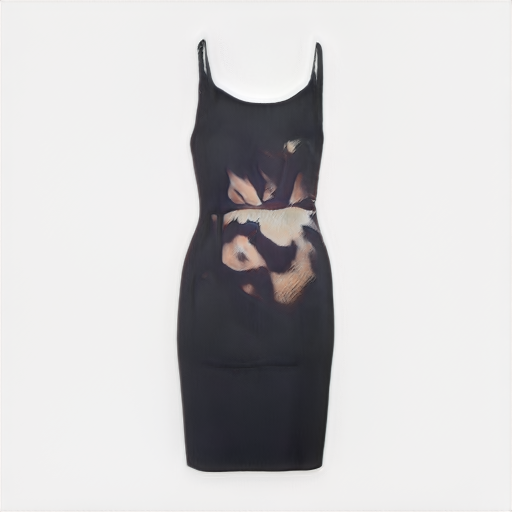

In [10]:
img